Fifth sandbox. Returning to the Decision Tree bootstrap.

# Imports and setup

In [2]:
import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
# https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
df = pd.read_csv('creditcard.csv')
print(df.columns)
print(df['Class'].value_counts())

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
Class
0    284315
1       492
Name: count, dtype: int64


In [4]:
X_all = df[df.columns[:-1]].values
y_all = df['Class'].values

# Helper functions

In [8]:
def fit_with_size(X_sample, y_sample, seed, train_size, verbose=False):
    X_train, X_test, y_train, y_test = train_test_split(
        X_sample, y_sample,
        train_size=train_size,
        stratify=y_sample,
        random_state=seed  # make less random
    )

    if verbose:
        print("Fitting model with", train_size, "of the data...", end=' ')
        start_time = time()
    np.random.seed(seed)  # make less random
    model = DecisionTreeClassifier().fit(X_train, y_train)
    if verbose:
        end_time = time()
        print("done in", round(end_time-start_time), "seconds.")

    return model, X_test, y_test

In [10]:
def get_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return precision, recall, f1

In [12]:
def plot_metrics(df):
    plt.subplot(1, 3, 1)
    df["Precision"].plot.barh()
    plt.title("Precision")
    plt.subplot(1, 3, 2)
    df["Recall"].plot.barh()
    plt.title("Recall")
    plt.subplot(1, 3, 3)
    df["F1"].plot.barh()
    plt.title("F1")

In [21]:
# https://www.kdnuggets.com/2023/03/bootstrapping.html
def bootstrap(X, y, n_samples, train_size):
    results = []
    for i in tqdm(range(n_samples)):
        run = {}
        np.random.seed(i)  # make less random
        indices = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
        X_sample = X[indices, :]
        y_sample = y[indices]

        model, X_test, y_test = fit_with_size(X_sample, y_sample, i, train_size)
        precision, recall, f1 = get_metrics(model, X_test, y_test)

        run["Seed"] = i
        run["Precision"] = precision
        run["Recall"] = recall
        run["F1"] = f1
        run["Indices"] = indices
        run["Model"] = model
        results.append(run)
    return pd.DataFrame(results)

In [17]:
def weighted_predict(X, y, df, weight_by=None):
    n = y.shape
    y_weighted = np.zeros(n)
    all_predictions = []
    all_metrics = []
    
    models = df['Model'].values
    if weight_by is None:
        weights = [1 for _ in range(n)]
    else:
        weights = df[weight_by].values

    print("Making predictions...")
    for model, weight in tqdm(zip(models, weights)):
        y_raw = model.predict(X)
        all_predictions.append(y_raw)  # save this off for later comparison
        y_pred = y_raw * 2 - 1  # transform to range [-1, 1]
        y_pred = y_pred * weight
        y_weighted += y_pred
    # predictions are now in a range such that:
    # y >= 0 means a positive classification
    # y < 0 means a negative classification
    y_weighted = y_weighted >= 0
    all_predictions.append(y_weighted)

    print("Getting metrics...")
    for prediction in tqdm(all_predictions):
        d = {}
        d["Precision"] = precision_score(y, prediction)
        d["Recall"] = recall_score(y, prediction)
        d["F1"] = f1_score(y, prediction)
        all_metrics.append(d)

    print("Done.")
    return pd.DataFrame(all_metrics)

# Split before training, then test upon holdout set

In [44]:
# Use 80% of the data for training
# The remaining 20% will be used for final metrics
X_bootstrap, X_holdout, y_bootstrap, y_holdout = train_test_split(
    X_all, y_all,
    train_size=0.8,
    stratify=y_all,
    random_state=10
)

In [46]:
results = bootstrap(X_bootstrap, y_bootstrap, 10, 0.6)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:10<00:00,  7.07s/it]


Making predictions...


10it [00:00, 168.51it/s]


Getting metrics...


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 46.02it/s]


Done.


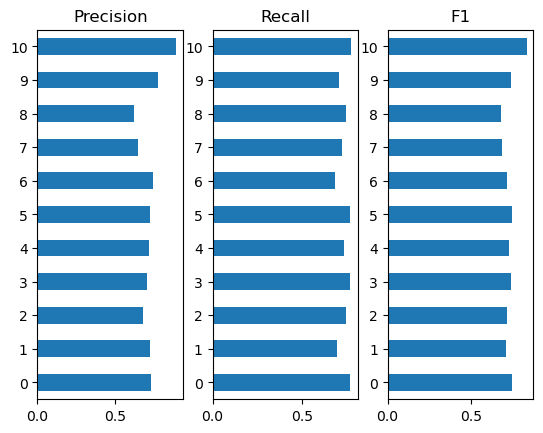

In [47]:
weighted = weighted_predict(X_holdout, y_holdout, results, 'Precision')
plot_metrics(weighted)

Making predictions...


10it [00:00, 173.77it/s]


Getting metrics...


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 46.19it/s]


Done.


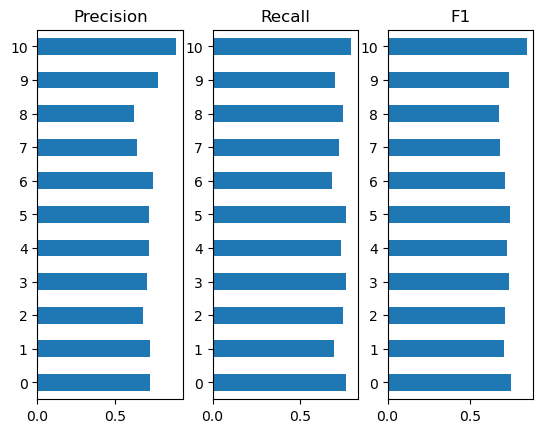

In [48]:
weighted = weighted_predict(X_holdout, y_holdout, results, 'Recall')
plot_metrics(weighted)

Making predictions...


10it [00:00, 167.72it/s]


Getting metrics...


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 46.76it/s]


Done.


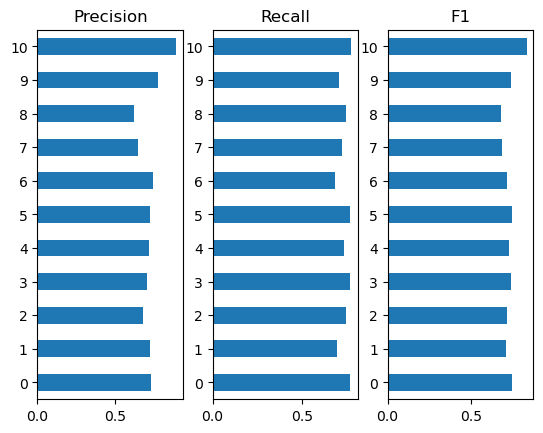

In [49]:
weighted = weighted_predict(X_holdout, y_holdout, results, 'F1')
plot_metrics(weighted)